# CNN-Based Analysis of Pressure Maps for Posture and User Classification

## Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/!MLHD project'

/content/drive/MyDrive/!MLHD project


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import time, psutil, os
from scipy.ndimage import rotate

## 1. PREPROCESSING PHASE

In [ ]:
path_file = '../!MLHD project/Dataset/SHA256SUMS.txt'
percorsi = []
elementi_da_escludere = ['experiment-i/subject-info-i.csv', 'experiment-ii/subject-info-ii.csv', 'experiment-info.docx']
with open(path_file, "r") as f:  # modalità read
    for line in f:
        parts = line.strip().split()  # Divide la riga per spazi o tab
        if len(parts) > 1:  # Se ci sono più parti, l'ultima è il percorso
            path_file = parts[-1]  # Prendi l'ultima parte della riga
            if path_file not in elementi_da_escludere:
              percorsi.append(path_file)

In [ ]:
print(len(percorsi))

686


In [ ]:
percorsi_exp_1 = percorsi[:13*17]
percorsi_exp_2 = percorsi[13*17:]

In [ ]:
# Check the shape of the records
path = np.loadtxt('../!MLHD project/Dataset/experiment-ii/S1/Air_Mat/Matrix_Air_B2.txt')
print(path.shape)

(64, 27)


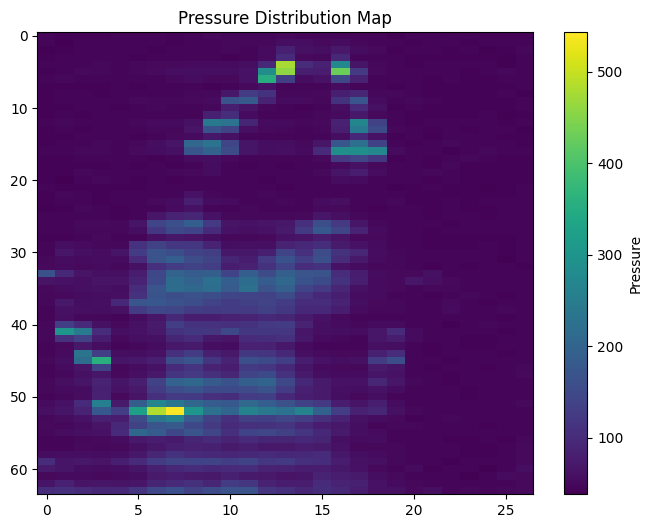

In [ ]:
# Create a visual representation of the pressure map
plt.figure(figsize=(8, 6))
plt.imshow(path, cmap="viridis", aspect="auto")
plt.colorbar(label="Pressure")
plt.title('Pressure Distribution Map')
plt.show()

In [ ]:
# Create a dataset of label (3 labels RIGHT, LEFT, SUPINE)
# Function to extract components and assign labels

def process_file_path(file_path):
    # Split the path into parts
    parts = file_path.split('/')
    flag = True
    if len(parts)==3:
        subject = int(parts[1][1:]) - 1
        measurement_number = int(parts[2][:-4]) # Extract measurement number

        # Assign label (example logic)
        if measurement_number in [2, 4, 5, 13]:
            label = 1 #right
        elif measurement_number in [3, 6, 7, 14]:
            label = 2 #left
        else:
            label = 0 #supine

        return file_path, subject, label, flag

    else:
        measurement_number = parts[3][-6:-4] # Extract measurement number
        subject = int(parts[1][1:]) - 1
        # Assign label (example logic)
        if measurement_number in ['C1', 'C2', 'C3', 'E1', 'E2', 'E5']:
            label = 1 #right
        elif measurement_number in ['D1', 'D2', 'D3', 'E3', 'E4', 'E6']:
            label = 2 #left
        else:
            label = 0 #supine
        flag = False

        return file_path, subject, label, flag

In [ ]:
# Process all file paths
data = [process_file_path(fp) for fp in percorsi]

# Create DataFrame
df_label = pd.DataFrame(data, columns=["Experiment", "Subject", "Label", "Sequence"]).set_index("Experiment")
df_label.index.name=None

In [ ]:
# Divide the train/val/test sets in terms of Label and Subjects
df_label['LabelSubject'] = df_label['Label'].astype(str) + "_" + df_label['Subject'].astype(str)

train_val_label_df, test_label_df = train_test_split(df_label,
                                                         test_size=0.1,
                                                         stratify=df_label['LabelSubject'],
                                                         random_state=123)
train_label_df, val_label_df = train_test_split(train_val_label_df,
                                                    test_size=0.15,
                                                    stratify=train_val_label_df['LabelSubject'],
                                                    random_state=123)

In [ ]:
# Drop the column created
df_label = df_label.drop('LabelSubject', axis=1)

In [ ]:
# Count the elements in the sets
num_train_data_supine = sum(train_label_df['Label'] == 0)
num_train_data_right = sum(train_label_df['Label'] == 1)
num_train_data_left = sum(train_label_df['Label'] == 2)
num_val_data_supine = sum(val_label_df['Label'] == 0)
num_val_data_right = sum(val_label_df['Label'] == 1)
num_val_data_left = sum(val_label_df['Label'] == 2)
num_test_data_supine = sum(test_label_df['Label'] == 0)
num_test_data_right = sum(test_label_df['Label'] == 1)
num_test_data_left = sum(test_label_df['Label'] == 2)

print('POSTURES DISTRIBUTION')
print('TRAIN SET')
print('\tSupine: {} ({:.2f}%)'.format(num_train_data_supine, 100 * num_train_data_supine / len(train_label_df)))
print('\tRight: {} ({:.2f}%)'.format(num_train_data_right, 100 * num_train_data_right / len(train_label_df)))
print('\tLeft: {} ({:.2f}%)'.format(num_train_data_left, 100 * num_train_data_left / len(train_label_df)))
print('VALIDATION SET')
print('\tSupine: {} ({:.2f}%)'.format(num_val_data_supine, 100 * num_val_data_supine / len(val_label_df)))
print('\tRight: {} ({:.2f}%)'.format(num_val_data_right, 100 * num_val_data_right / len(val_label_df)))
print('\tLeft: {} ({:.2f}%)'.format(num_val_data_left, 100 * num_val_data_left / len(val_label_df)))
print('TEST SET')
print('\tSupine: {} ({:.2f}%)'.format(num_test_data_supine, 100 * num_test_data_supine / len(test_label_df)))
print('\tRight: {} ({:.2f}%)'.format(num_test_data_right, 100 * num_test_data_right / len(test_label_df)))
print('\tLeft: {} ({:.2f}%)'.format(num_test_data_left, 100 * num_test_data_left / len(test_label_df)))

print('\nSUBJECTS DISTRIBUTION')
for i in range(13):
  num_train_data = sum(train_label_df['Subject'] == i)
  num_val_data = sum(val_label_df['Subject'] == i)
  num_test_data = sum(test_label_df['Subject'] == i)
  print('SUBJECT {}:'.format(i+1))
  print('\tTrain: {} ({:.2f}%)'.format(num_train_data, 100 * num_train_data / len(train_label_df)))
  print('\tVal: {} ({:.2f}%)'.format(num_val_data, 100 * num_val_data / len(val_label_df)))
  print('\tTest: {} ({:.2f}%)'.format(num_test_data, 100 * num_test_data / len(test_label_df)))

POSTURES DISTRIBUTION
TRAIN SET
	Supine: 300 (57.25%)
	Right: 113 (21.56%)
	Left: 111 (21.18%)
VALIDATION SET
	Supine: 52 (55.91%)
	Right: 20 (21.51%)
	Left: 21 (22.58%)
TEST SET
	Supine: 38 (55.07%)
	Right: 15 (21.74%)
	Left: 16 (23.19%)

SUBJECTS DISTRIBUTION
SUBJECT 1:
	Train: 57 (10.88%)
	Val: 10 (10.75%)
	Test: 8 (11.59%)
SUBJECT 2:
	Train: 57 (10.88%)
	Val: 10 (10.75%)
	Test: 8 (11.59%)
SUBJECT 3:
	Train: 59 (11.26%)
	Val: 10 (10.75%)
	Test: 9 (13.04%)
SUBJECT 4:
	Train: 57 (10.88%)
	Val: 10 (10.75%)
	Test: 8 (11.59%)
SUBJECT 5:
	Train: 57 (10.88%)
	Val: 10 (10.75%)
	Test: 8 (11.59%)
SUBJECT 6:
	Train: 57 (10.88%)
	Val: 10 (10.75%)
	Test: 8 (11.59%)
SUBJECT 7:
	Train: 57 (10.88%)
	Val: 9 (9.68%)
	Test: 7 (10.14%)
SUBJECT 8:
	Train: 57 (10.88%)
	Val: 10 (10.75%)
	Test: 8 (11.59%)
SUBJECT 9:
	Train: 13 (2.48%)
	Val: 3 (3.23%)
	Test: 1 (1.45%)
SUBJECT 10:
	Train: 13 (2.48%)
	Val: 3 (3.23%)
	Test: 1 (1.45%)
SUBJECT 11:
	Train: 13 (2.48%)
	Val: 3 (3.23%)
	Test: 1 (1.45%)
SUBJECT 12:
	

### Load image

In [ ]:
# Load data images
def load_image(file_name, dir_name):
  if isinstance(dir_name, bytes):
      dir_name = dir_name.decode()
  if isinstance(file_name, bytes):
      file_name = file_name.decode()
  file_path = dir_name + '/' + file_name
  data = np.loadtxt(file_path, dtype=int)
  if not data.shape == (64, 32):
    num_frames = data.shape[0]
  # Reshape in (num_frames, 32, 64) se il numero di righe è multiplo di 32
    if data.shape[1] % 32 == 0:
      data = data.reshape(num_frames, 64, 32)
  return data

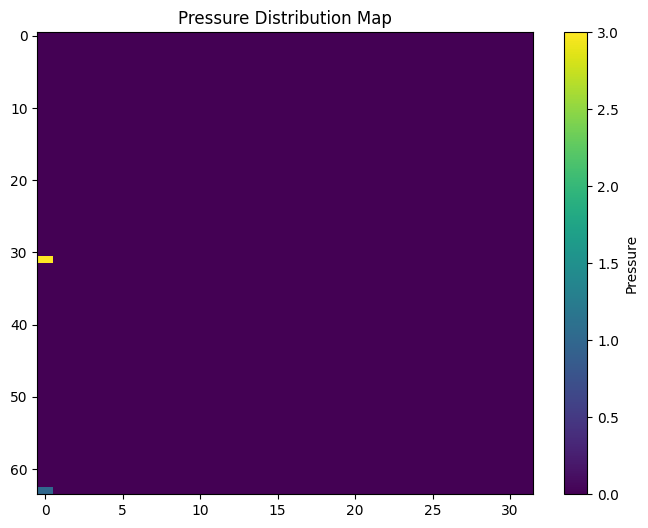

(90, 64, 32)


In [ ]:
# CHECK THE FIRST AND THE LAST FRAMES OF A RECORDING
file_name = 'experiment-i/S1/3.txt'
dir_name = '../!MLHD project/Dataset'
frame = 0

plt.figure(figsize=(8, 6))
plt.imshow(load_image(file_name, dir_name)[frame], cmap="viridis", aspect="auto")
plt.colorbar(label="Pressure")
plt.title('Pressure Distribution Map')
plt.show()
print(load_image(file_name, dir_name).shape)

### Remove frames

In [ ]:
# REMOVE FIRST 3 AND LAST 3 FRAMES FOR EACH RECORDING
def remove_frames(data):
  if len(data.shape)==3:
    if data.shape[0] > 8:
      data = data[4:-4]
  return data

(70, 64, 32)


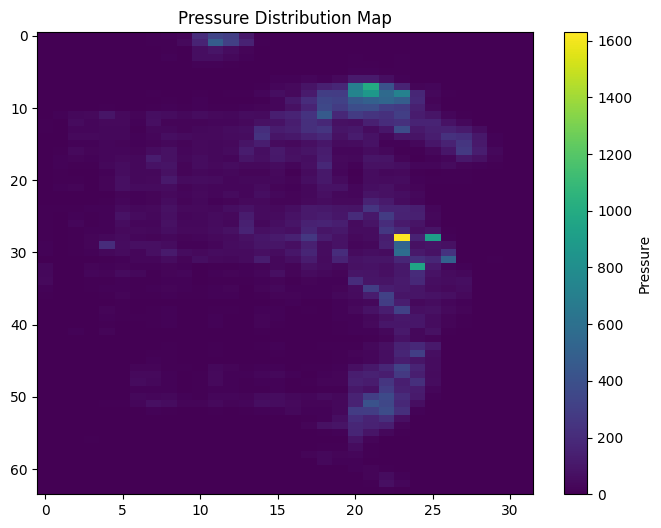

In [ ]:
file_name = 'experiment-i/S1/5.txt'
data = load_image(file_name, '../!MLHD project/Dataset')
data = remove_frames(data)
frame = 0

plt.figure(figsize=(8, 6))
plt.imshow(data[frame], cmap="viridis", aspect="auto")
plt.colorbar(label="Pressure")
plt.title('Pressure Distribution Map')
plt.show()

### Filter image

In [ ]:
# APPLY A FILTER TO REMOVE THE NOISE
def filtered_data(pressure_data):
     if pressure_data.ndim == 3:
        return median_filter(pressure_data, size=(3, 3, 3))
     elif pressure_data.ndim == 2:
        return median_filter(pressure_data, size=(3, 3))
     else:
        raise ValueError(f"filtered_temp_data: rank inatteso {pressure_data.ndim}, shape={pressure_data.shape}")

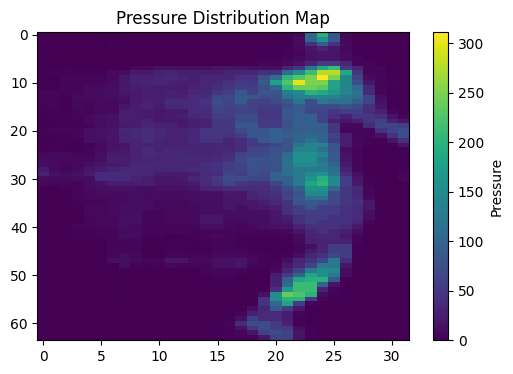

In [ ]:
file_name = 'experiment-i/S5/5.txt'
dir_name = '../!MLHD project/Dataset'
frame = 0
data = load_image(file_name, dir_name)
data = remove_frames(data)[frame]
filter_data = filtered_data(data)

plt.figure(figsize=(6, 4))
plt.imshow(filter_data, cmap="viridis", aspect="auto")
plt.colorbar(label="Pressure")
plt.title('Pressure Distribution Map')
plt.show()

### Normalize image

In [ ]:
# NORMALIZATION
def normalize_data(data):
  return (data - np.min(data)) / (np.max(data) - np.min(data))

In [ ]:
file_name = 'experiment-ii/S5/Sponge_Mat/Matrix_Sponge_E6.txt'
dir_name = '../!MLHD project/Dataset'
data = load_image(file_name, dir_name)
filter_data = filtered_data(data)
norm_data = normalize_data(filter_data)


plt.figure(figsize=(6, 4))
plt.imshow(norm_data, cmap="viridis", aspect="auto")
plt.colorbar(label="Pressure")
plt.title('Pressure Distribution Map')
plt.show()

In [ ]:
# CHECK IF THERE ARE SAMPLES THAT CONTAIN NO IMAGES
j=0
for path in percorsi_exp_1:
  data = load_image(path, '../!MLHD project/Dataset')
  processed_data = remove_frames(data)
  processed_data = filtered_data(processed_data)
  for frame in processed_data:
      if np.isnan(data).any() or np.sum(data) <= 10 or np.size(data)==0:
        j+=1
        print('Path: ' + path + ' - N. frame: ' + str(frame))
for path in percorsi_exp_2:
    data = load_image(path, '../!MLHD project/Dataset')
    data = filtered_data(data)
    if np.isnan(data).any() or np.sum(data) <= 10 or np.size(data)==0:
        j+=1
        print('Path: ' + path)
print('Number of samples that contain no image: '+str(j))

Number of samples that contain no image: 0


### Padding

In [ ]:
def padding_2d(data):
    if data.ndim == 2:  # immagine singola
        if data.shape == (64, 27):
            return np.pad(data, ((0, 0), (2, 3)), mode='constant', constant_values=0)
        if data.shape == (64, 32):
            return data
    if data.ndim == 3:
        return data

In [ ]:
def is_static_sequence(shape, tol=1e-2):
    diffs = []
    for t in range(1, shape.shape[0]):
        diff = np.mean((shape[t] - shape[t-1])**2) #Mse between two consecutive frames
        diffs.append(diff)
    max_diff = np.max(diffs)
    return max_diff < tol, max_diff

In [ ]:
# check if there is a significant variation in every sequence of frames
dir_name = '../!MLHD project/Dataset'
for path in percorsi_exp_1:
  data = load_image(path, dir_name)
  data = remove_frames(data)
  data = filtered_data(data)
  data = normalize_data(data)
  static, max_diff = is_static_sequence(data)
  if not static:
    print(path)
    print(max_diff)

In [ ]:
path = 'experiment-ii/S5/Sponge_Mat/Matrix_Sponge_E6.txt'
data = load_image(path, '../!MLHD project/Dataset')
data = filtered_data(data)
data = normalize_data(data)
data = padding_2d(data)
print(data.shape)

(64, 32)


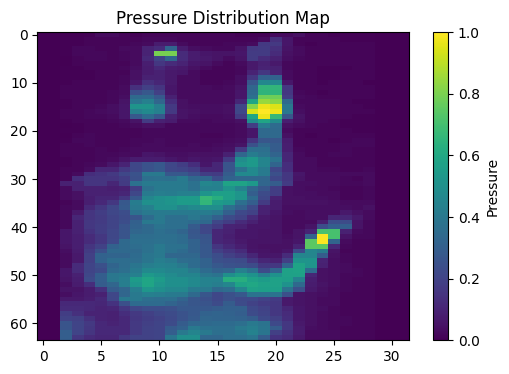

In [ ]:
plt.figure(figsize=(6, 4))
plt.imshow(data, cmap="viridis", aspect="auto")
plt.colorbar(label="Pressure")
plt.title('Pressure Distribution Map')
plt.show()

In [ ]:
def media(data):
  return np.mean(data, axis=0)

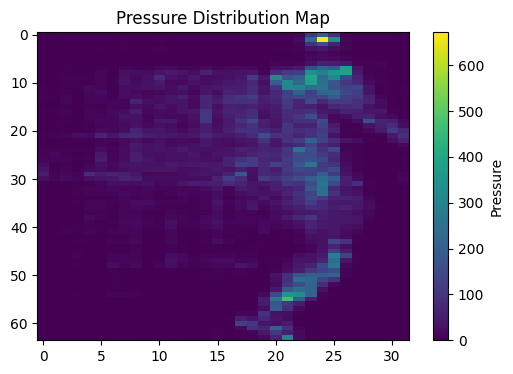

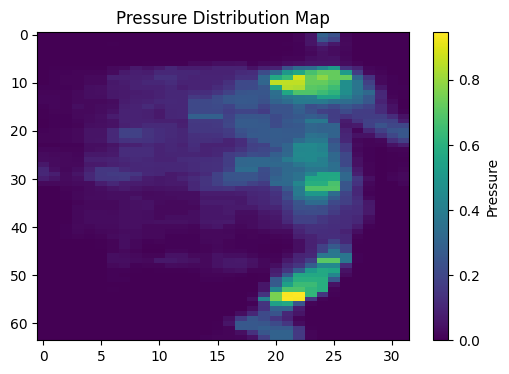

In [ ]:
path = 'experiment-i/S5/5.txt'
data = load_image(path, '../!MLHD project/Dataset')


plt.figure(figsize=(6, 4))
plt.imshow(data[2], cmap="viridis", aspect="auto")
plt.colorbar(label="Pressure")
plt.title('Pressure Distribution Map')
plt.show()

data = filtered_data(data)
data = normalize_data(data)

plt.figure(figsize=(6, 4))
plt.imshow(data[2], cmap="viridis", aspect="auto")
plt.colorbar(label="Pressure")
plt.title('Pressure Distribution Map')
plt.show()

## 2. DATASET

In [ ]:
def load_process_data(file_name, subject, label):
    file_path = file_name.numpy().decode("utf-8")
    data = load_image(file_path, '../!MLHD project/Dataset')

    if data.ndim==3:
      data = preprocess_sequence(data)
    elif data.ndim==2:
      data = preprocess_single_image(data)
    else:
      raise ValueError(f"load_process_data: shape inattesa {data.shape}")
    return data.astype(np.float32), subject, label

def preprocess_sequence(data):
    data = remove_frames(data)
    data = filtered_data(data)
    data = normalize_data(data)
    data = media(data)
    return data

def preprocess_single_image(data):
    data = padding_2d(data)
    data = filtered_data(data)
    data = normalize_data(data)
    return data

In [ ]:
def create_dataset(label_df, shuffle, cache_file=None, batch_size=None):
  file_names = list(label_df.index)
  labels = label_df['Label']
  subjects = label_df['Subject']

  dataset = tf.data.Dataset.from_tensor_slices((file_names, subjects, labels))

  def tf_wrapper(file_name, subject, label):
    data, subject, label = tf.py_function(
        func=lambda f, s, l:load_process_data(f, s, l),
        inp=[file_name, subject, label],
        Tout=[tf.float32, tf.int64, tf.int64])
    data.set_shape([64, 32])
    subject.set_shape([])
    label.set_shape([])
    return data, subject, label

  dataset = dataset.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)

  if cache_file:
    dataset = dataset.cache(cache_file)

  if shuffle:
    dataset = dataset.shuffle(buffer_size=len(file_names))

  dataset = dataset.repeat()

  def format_for_model(data, subject, label):
        data_rgb = tf.stack([data, data, data], axis=-1)  #stack su 3 canali
        return data_rgb, (label, subject) # Return data_rgb and a tuple of labelsiiB

  dataset = dataset.map(format_for_model, num_parallel_calls=tf.data.AUTOTUNE) # Map the new format function

  if batch_size:
    dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset

In [ ]:
batch_size=32
train_dataset = create_dataset(train_label_df,
                                  batch_size=batch_size,
                                  shuffle=True)
val_dataset = create_dataset(val_label_df,
                                batch_size=batch_size,
                                shuffle=False)
test_dataset = create_dataset(test_label_df,
                                 batch_size=batch_size,
                                 shuffle=False)

## MODELS

### Model

In [ ]:
def cnn2d(input_shape, num_postures=3, num_subjects=13):
        inp = layers.Input(shape=input_shape)  # (H, W, C)
        x = layers.Conv2D(32, (3,3), strides=1, padding="valid")(inp)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(negative_slope=0.2)(x)
        x = layers.MaxPooling2D((2,2))(x)

        x = layers.Conv2D(64, (3,3), strides=1, padding="valid")(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(negative_slope=0.2)(x)
        x = layers.MaxPooling2D((2,2))(x)
        x = layers.Dropout(0.2)(x)

        x = layers.Conv2D(128, (3,3), strides=1, padding="valid")(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(negative_slope=0.2)(x)

        x = layers.Flatten()(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.4)(x)

        posture_output = layers.Dense(num_postures, activation="softmax", name="posture")(x)
        subject_output = layers.Dense(num_subjects, activation="softmax", name="subject")(x)

        model = models.Model(inputs=inp, outputs=[posture_output, subject_output], name="cnn2d_model")
        return model

In [ ]:
input_shape = (64, 32, 3)
model_cnn2d = cnn2d(input_shape)
#model_cnn2d.summary()

In [ ]:
lambda_ = 0.5
lr = 2e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model_cnn2d.compile(optimizer=optimizer, loss={'posture':tf.keras.losses.SparseCategoricalCrossentropy(),
                                      'subject':tf.keras.losses.SparseCategoricalCrossentropy()},
              loss_weights={'posture':lambda_,
                            'subject':1-lambda_},
              metrics={'posture':[tf.keras.metrics.SparseCategoricalAccuracy()],
                       'subject':[tf.keras.metrics.SparseCategoricalAccuracy()]})

In [ ]:
num_epochs = 40
batch_size = 32
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch > 0 and epoch % 5 == 0:
        return lr * 0.90
    return lr

callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

train_steps = int(np.ceil(len(train_label_df)/batch_size))
val_steps = int(np.ceil(len(val_label_df)/batch_size))


process = psutil.Process(os.getpid())

start = time.time()
history = model_cnn2d.fit(train_dataset,
                            validation_data=val_dataset,
                            validation_steps=val_steps,
                            epochs=num_epochs,
                            steps_per_epoch=train_steps,
                            callbacks=[early_stop, callback_lr])
end = time.time()
print(f"Training phase: {end - start:.2f} seconds")
mem_info = process.memory_info().rss / (1024 ** 2)  # in MB
print(f"Memory used: {mem_info:.2f} MB")

In [ ]:
#model_cnn2d.save('cnn_noaugm_withval.keras')
model_cnn2d = models.load_model('cnn_noaugm_withval.keras')

In [ ]:
# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot POSTURE accuracy
plt.figure()
plt.plot(history.history['posture_sparse_categorical_accuracy'], label='Train posture accuracy')
plt.plot(history.history['val_posture_sparse_categorical_accuracy'], label='Val posture accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Posture Accuracy')

# Plot POSTURE loss
plt.figure()
plt.plot(history.history['posture_loss'], label='Train posture loss')
plt.plot(history.history['val_posture_loss'], label='Val posture loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Posture Loss')

# Plot SUBJECT accuracy
plt.figure()
plt.plot(history.history['subject_sparse_categorical_accuracy'], label='Train subject accuracy')
plt.plot(history.history['val_subject_sparse_categorical_accuracy'], label='Val subject accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Subject Accuracy')

# Plot SUBJECT loss
plt.figure()
plt.plot(history.history['subject_loss'], label='Train subject loss')
plt.plot(history.history['val_subject_loss'], label='Val subject loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Subject Loss')

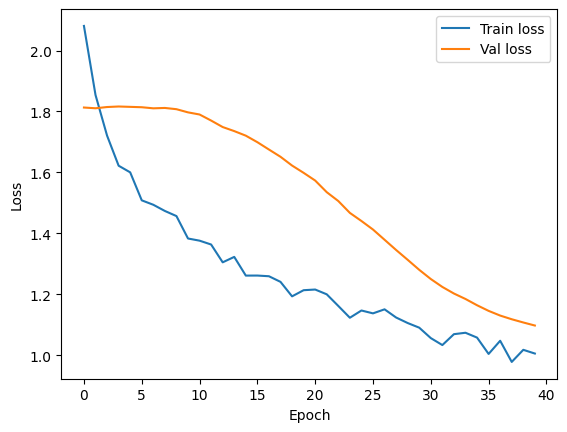

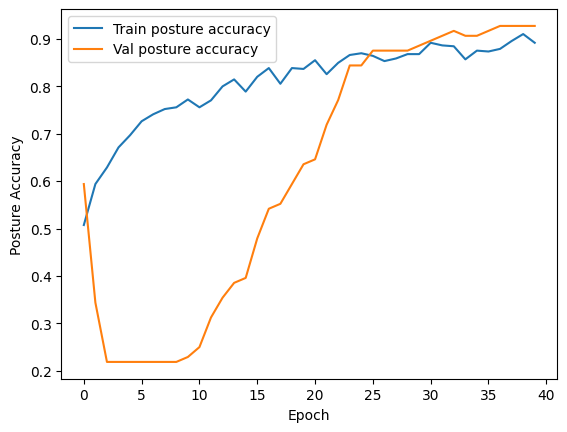

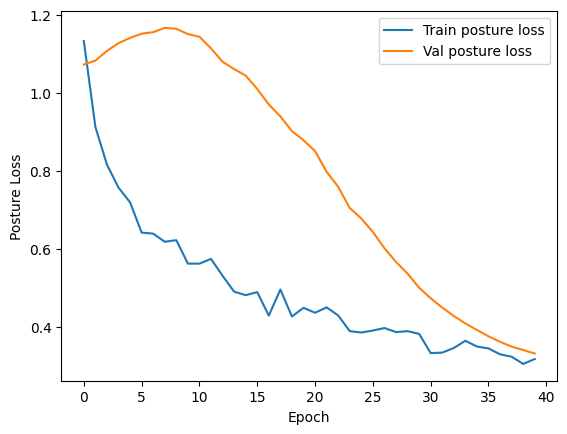

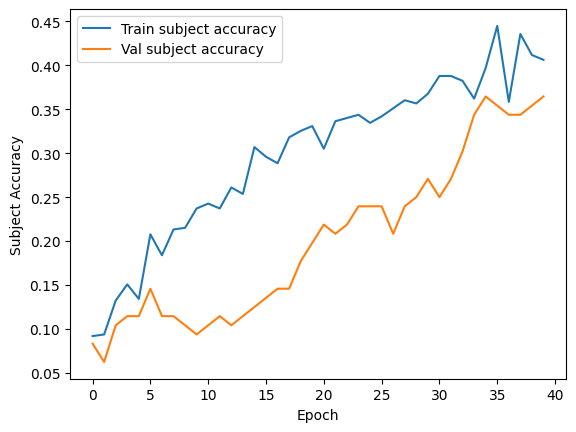

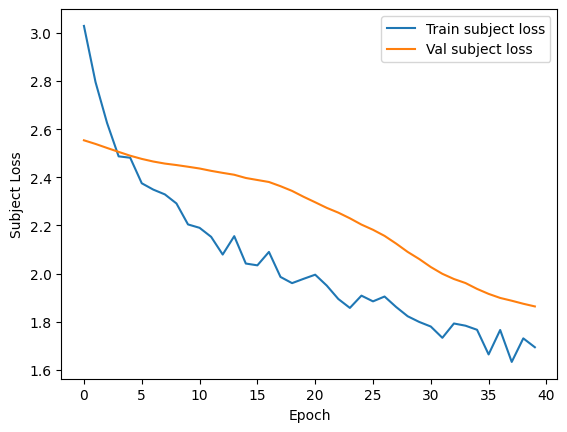

### FINE-TUNING with Kfold CV

In [ ]:
def run_kfold(label_df, num_folds=3, epochs=5, batch_size=32, learning_rate=1e-5, lambda_=[]):
    results=[]
    for l in lambda_:

          skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

          X = np.array(label_df.index)  # file_names
          y = label_df['Label'].values  # posture labels

          all_posture_acc = []
          all_subject_acc = []

          fold = 1
          for train_idx, val_idx in skf.split(X, y):
              print(f"\n Fold {fold}/{num_folds}")

              train_df = label_df.iloc[train_idx]
              val_df   = label_df.iloc[val_idx]

              train_ds = create_dataset(train_df,
                                        batch_size=batch_size, shuffle=True)
              val_ds   = create_dataset(val_df,
                                        batch_size=batch_size, shuffle=False)

              # Model
              input_shape = (64, 32, 3)  # dopo tf.stack diventa (H, W, 3)
              model = cnn2d(input_shape)

              model.compile(
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss={
                      "posture": "sparse_categorical_crossentropy",
                      "subject": "sparse_categorical_crossentropy"
                  },
                  loss_weights={"posture": 1 - l, "subject": l},
                  metrics={
                      "posture": "sparse_categorical_accuracy",
                      "subject": "sparse_categorical_accuracy"
                  }
              )

              steps_per_epoch = len(train_df) // batch_size
              val_steps = len(val_df) // batch_size

              model.fit(train_ds,
                        epochs=epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=val_ds,
                        validation_steps=val_steps,
                        verbose=1)

              scores = model.evaluate(val_ds, steps=val_steps, verbose=0)
              print(f"Posture acc: {scores[3]:.4f}, Subject acc: {scores[4]:.4f}")

              all_posture_acc.append(scores[3])
              all_subject_acc.append(scores[4])

              tf.keras.backend.clear_session()
              fold += 1

          results.append({
                    "lambda": l,
                    "posture_acc_mean": np.mean(all_posture_acc),
                    "subject_acc_mean": np.mean(all_subject_acc),
                })

          print(f"\n Final results ({num_folds}-fold) - lambda: {l}:")
          print(f"Posture acc mean: {np.mean(all_posture_acc):.4f}")
          print(f"Subject acc mean: {np.mean(all_subject_acc):.4f}")

    results_sorted = sorted(results, key=lambda x: x["posture_acc_mean"] + x["subject_acc_mean"], reverse=True)

    print("\n Top 3 best combinations (by Posture acc mean + Subject acc mean):")
    for rank, res in enumerate(results_sorted[:3], start=1):
        print(f"\n #{rank}")
        print(f"Lambda: {res['lambda']}")
        print(f"Posture acc media: {res['posture_acc_mean']:.4f}")
        print(f"Subject acc media: {res['subject_acc_mean']:.4f}")

In [ ]:
run_kfold(df_label, num_folds=3, epochs=10, batch_size=32, lambda_=[0.3, 0.5, 0.7], learning_rate=2e-5)


 Fold 1/3
Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 1.9485 - posture_loss: 1.4902 - posture_sparse_categorical_accuracy: 0.3330 - subject_loss: 3.0177 - subject_sparse_categorical_accuracy: 0.0829 - val_loss: 1.5437 - val_posture_loss: 1.1065 - val_posture_sparse_categorical_accuracy: 0.2232 - val_subject_loss: 2.5639 - val_subject_sparse_categorical_accuracy: 0.0268
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 1.7055 - posture_loss: 1.2224 - posture_sparse_categorical_accuracy: 0.4484 - subject_loss: 2.8330 - subject_sparse_categorical_accuracy: 0.0933 - val_loss: 1.5407 - val_posture_loss: 1.1026 - val_posture_sparse_categorical_accuracy: 0.2321 - val_subject_loss: 2.5630 - val_subject_sparse_categorical_accuracy: 0.0268
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 1.5998 - posture_loss: 1.0548 - posture_sparse_categorical_accuracy: 0.5365 - subject_loss: 2.8715 - subject_sparse_categorical_accuracy: 0.0978 - val_loss: 1.5473 - val_posture_l

### AUGMENTATION

In [ ]:
def augment_image(image):

  # Horizontal flip
  if np.random.rand() < 0.5:
        image = np.flipud(image)

  # Random rotation betwwen -25° and +25°
  if np.random.rand() < 0.5:
    image = rotate(image, angle=25, reshape=False, mode='reflect')

  # Random translation (up to ±10% of image size)
  if np.random.rand() < 0.5:
        h, w = image.shape[:2]
        shift_x = int(np.random.uniform(-0.1, 0.1) * w)
        shift_y = int(np.random.uniform(-0.1, 0.1) * h)
        image = np.roll(image, shift=(shift_y, shift_x), axis=(0,1))

  # Guassian noise
  if np.random.rand() < 0.5:
    noise = np.random.normal(scale=0.01, size=image.shape)
    noise = noise.astype('float32')
    image = image + noise

  image = np.clip(image, 0.0, 1.0).astype('float32')

  return image

In [ ]:
def create_dataset_augment(label_df, batch_size=None, shuffle=False, augment=False, cache_file=None):
  file_names = list(label_df.index)
  labels = label_df['Label']
  subjects = label_df['Subject']

  dataset = tf.data.Dataset.from_tensor_slices((file_names, subjects, labels))

  def tf_wrapper(file_name, subject, label):
    data, subject, label = tf.py_function(
        func=lambda f, s, l:load_process_data(f, s, l),
        inp=[file_name, subject, label],
        Tout=[tf.float32, tf.int64, tf.int64])
    data.set_shape([64, 32])
    subject.set_shape([])
    label.set_shape([])
    return data, subject, label

  dataset = dataset.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)

  if cache_file:
    dataset = dataset.cache(cache_file)

  if shuffle:
    dataset = dataset.shuffle(buffer_size=len(file_names))

  dataset = dataset.repeat()

  if augment:
    py_func = lambda data, subject, label: (tf.numpy_function(func=augment_image, inp=[data], Tout=tf.float32))
    dataset.map(py_func, num_parallel_calls=tf.data.AUTOTUNE)

  def format_for_model(data, subject, label):
    data_rgb = tf.stack([data, data, data], axis=-1)
    return data_rgb, (label, subject)

  dataset = dataset.map(format_for_model, num_parallel_calls=tf.data.AUTOTUNE)
  if batch_size:
    dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset

In [ ]:
batch_size=32
train_dataset_augment = create_dataset_augment(train_label_df,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  augment=True)
val_dataset_augment = create_dataset_augment(val_label_df,
                                batch_size=batch_size,
                                shuffle=False,
                                augment=False)
test_dataset_augment = create_dataset_augment(test_label_df,
                                 batch_size=batch_size,
                                 shuffle=False,
                                 augment=False)

## TRAINING and EVALUATION


### Training and evaluation WITHOUT augmentation

In [ ]:
train = create_dataset(train_val_label_df, batch_size=batch_size, shuffle=True)
test = create_dataset(test_label_df, batch_size=batch_size, shuffle=False)
test_steps = int(np.ceil(len(test_label_df)/batch_size))

In [ ]:
input_shape = (64, 32, 3)
model_cnn2d_noval = cnn2d(input_shape)

lambda_ = 0.7
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
model_cnn2d_noval.compile(optimizer=optimizer, loss={'posture':tf.keras.losses.SparseCategoricalCrossentropy(),
                                      'subject':tf.keras.losses.SparseCategoricalCrossentropy()},
              loss_weights={'posture':lambda_,
                            'subject':1-lambda_},
              metrics={'posture':[tf.keras.metrics.SparseCategoricalAccuracy()],
                       'subject':[tf.keras.metrics.SparseCategoricalAccuracy()]})

num_epochs = 40

def scheduler(epoch, lr):
    if epoch > 0 and epoch % 5 == 0:
        return lr * 0.90
    return lr

callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
process = psutil.Process(os.getpid())

start = time.time()
train_steps = int(np.ceil(len(train_val_label_df)/batch_size))
test_steps = int(np.ceil(len(test_label_df)/batch_size))
history = model_cnn2d_noval.fit(train,
                            epochs=num_epochs,
                            steps_per_epoch=train_steps,
                            callbacks=[callback_lr])
end = time.time()
print(f"Training phase: {end - start:.2f} seconds")
mem_info = process.memory_info().rss / (1024 ** 2)  # in MB
print(f"Memory used: {mem_info:.2f} MB")


Epoch 1/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 695ms/step - loss: 2.1726 - posture_loss: 1.7311 - posture_sparse_categorical_accuracy: 0.3086 - subject_loss: 3.2027 - subject_sparse_categorical_accuracy: 0.0992 - learning_rate: 1.0000e-05
Epoch 2/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 825ms/step - loss: 1.7550 - posture_loss: 1.1421 - posture_sparse_categorical_accuracy: 0.5072 - subject_loss: 3.1853 - subject_sparse_categorical_accuracy: 0.1275 - learning_rate: 1.0000e-05
Epoch 3/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 809ms/step - loss: 1.6565 - posture_loss: 1.0749 - posture_sparse_categorical_accuracy: 0.5628 - subject_loss: 3.0136 - subject_sparse_categorical_accuracy: 0.1063 - learning_rate: 1.0000e-05
Epoch 4/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 822ms/step - loss: 1.5154 - posture_loss: 0.9102 - posture_sparse_categorical_accuracy: 0.5971 - subject_loss: 2.9273 - subject_sparse_categorical_accuracy: 0.0880 - learning_rate: 1.0000e-05
Epoch 5/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 875ms/step - loss: 1.4

In [ ]:
# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot POSTURE accuracy
plt.figure()
plt.plot(history.history['posture_sparse_categorical_accuracy'], label='Train posture accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Posture Accuracy')

# Plot POSTURE loss
plt.figure()
plt.plot(history.history['posture_loss'], label='Train posture loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Posture Loss')

# Plot SUBJECT accuracy
plt.figure()
plt.plot(history.history['subject_sparse_categorical_accuracy'], label='Train subject accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Subject Accuracy')

# Plot SUBJECT loss
plt.figure()
plt.plot(history.history['subject_loss'], label='Train subject loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Subject Loss')

In [ ]:
#model_cnn2d_noval.save('cnn_noaugm_noval.keras')
model_cnn2d_noaugm = models.load_model('cnn_noaugm_noval.keras')

### Training and evaluation WITH augmentation

In [ ]:
train_augm = create_dataset_augment(train_val_label_df, batch_size=batch_size, shuffle=True, augment=True)

In [ ]:
input_shape = (64, 32, 3)
model_cnn2d_augm = cnn2d(input_shape)

lambda_ = 0.5
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
model_cnn2d_augm.compile(optimizer=optimizer, loss={'posture':tf.keras.losses.SparseCategoricalCrossentropy(),
                                      'subject':tf.keras.losses.SparseCategoricalCrossentropy()},
              loss_weights={'posture':lambda_,
                            'subject':1-lambda_},
              metrics={'posture':[tf.keras.metrics.SparseCategoricalAccuracy()],
                       'subject':[tf.keras.metrics.SparseCategoricalAccuracy()]})

num_epochs = 40

def scheduler(epoch, lr):
    if epoch > 0 and epoch % 5 == 0:
        return lr * 0.90
    return lr

callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
process = psutil.Process(os.getpid())

start = time.time()
train_steps = int(np.ceil(len(train_val_label_df)/batch_size))

history_augm = model_cnn2d_augm.fit(train_augm,
                            epochs=num_epochs,
                            steps_per_epoch=train_steps,
                            callbacks=[callback_lr])
end = time.time()
print(f"Training phase: {end - start:.2f} seconds")
mem_info = process.memory_info().rss / (1024 ** 2)  # in MB
print(f"Memory used: {mem_info:.2f} MB")


Epoch 1/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 665ms/step - loss: 2.2692 - posture_loss: 1.4195 - posture_sparse_categorical_accuracy: 0.3432 - subject_loss: 3.1188 - subject_sparse_categorical_accuracy: 0.0932 - learning_rate: 1.0000e-05
Epoch 2/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 848ms/step - loss: 2.0166 - posture_loss: 1.1183 - posture_sparse_categorical_accuracy: 0.5032 - subject_loss: 2.9148 - subject_sparse_categorical_accuracy: 0.0941 - learning_rate: 1.0000e-05
Epoch 3/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 817ms/step - loss: 1.9227 - posture_loss: 0.9946 - posture_sparse_categorical_accuracy: 0.5835 - subject_loss: 2.8508 - subject_sparse_categorical_accuracy: 0.1048 - learning_rate: 1.0000e-05
Epoch 4/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 853ms/step - loss: 1.7668 - posture_loss: 0.8358 - posture_sparse_categorical_accuracy: 0.6412 - subject_loss: 2.6979 - subject_sparse_categorical_accuracy: 0.0904 - learning_rate: 1.0000e-05
Epoch 5/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 947ms/step - loss: 1.7

Text(0, 0.5, 'Subject Loss')

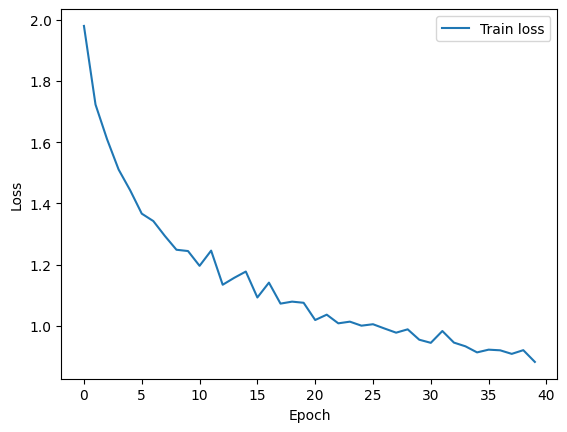

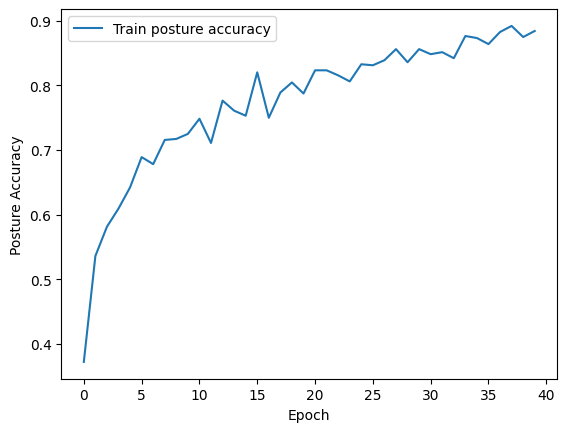

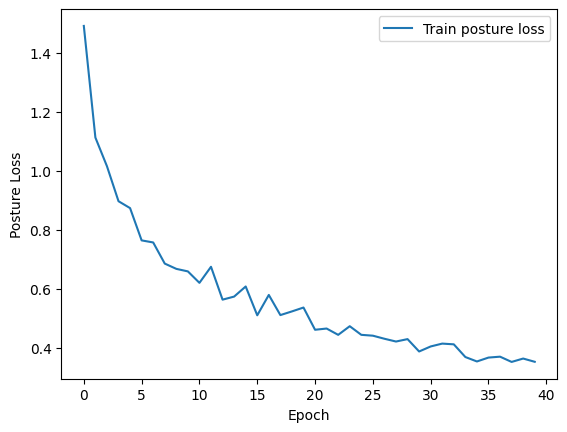

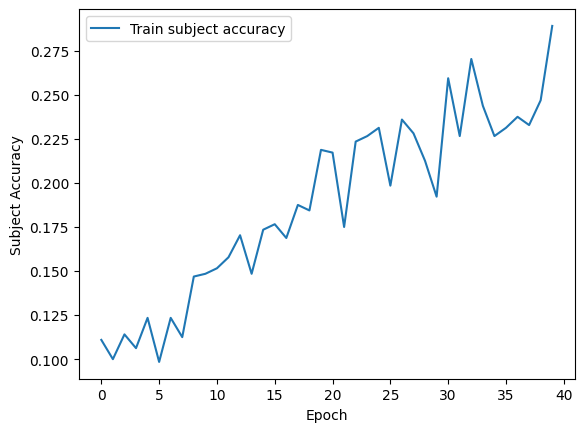

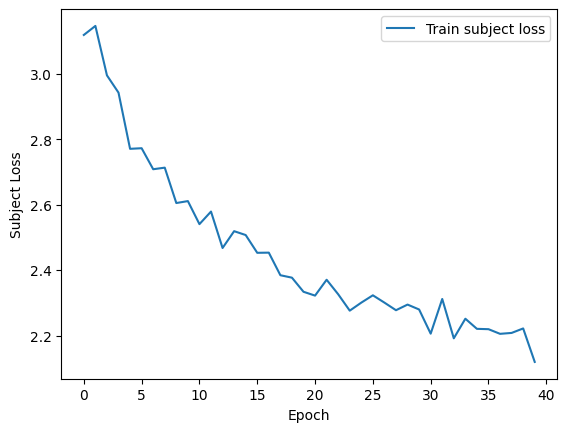

In [ ]:
# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot POSTURE accuracy
plt.figure()
plt.plot(history.history['posture_sparse_categorical_accuracy'], label='Train posture accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Posture Accuracy')

# Plot POSTURE loss
plt.figure()
plt.plot(history.history['posture_loss'], label='Train posture loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Posture Loss')

# Plot SUBJECT accuracy
plt.figure()
plt.plot(history.history['subject_sparse_categorical_accuracy'], label='Train subject accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Subject Accuracy')

# Plot SUBJECT loss
plt.figure()
plt.plot(history.history['subject_loss'], label='Train subject loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Subject Loss')

In [ ]:
#model_cnn2d_augm.save('cnn_augm_noval.keras')
model_cnn2d_augm = models.load_model('cnn_augm_noval.keras')

## COMPARISON with Model of paper and other models

### Model Paper

In [ ]:
def Model_paper(input_shape, num_postures=3, num_subjects=13):
        inp = layers.Input(shape=input_shape)  # (H, W, C)
        x = layers.Conv2D(32, (3,3), strides=1, padding="valid")(inp)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(negative_slope=0.2)(x)
        x = layers.MaxPooling2D((2,2))(x)
        x = layers.Dropout(0.1)(x)

        x = layers.Conv2D(64, (3,3), strides=1, padding="valid")(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(negative_slope=0.2)(x)
        x = layers.MaxPooling2D((2,2))(x)
        x = layers.Dropout(0.2)(x)

        x = layers.Conv2D(128, (3,3), strides=1, padding="valid")(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(negative_slope=0.2)(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(256, (3,3), strides=1, padding="valid")(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(negative_slope=0.2)(x)
        x = layers.Dropout(0.4)(x)

        x = layers.Flatten()(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dropout(0.5)(x)

        posture_output = layers.Dense(num_postures, activation="softmax", name="posture")(x)
        subject_output = layers.Dense(num_subjects, activation="softmax", name="subject")(x)

        model = models.Model(inputs=inp, outputs=[posture_output, subject_output], name="cnn2d_model")
        return model

In [ ]:
input_shape = (64, 32, 3)
model_paper = Model_paper(input_shape)

lambda_ = 0.5
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
model_paper.compile(optimizer=optimizer, loss={'posture':tf.keras.losses.SparseCategoricalCrossentropy(),
                                      'subject':tf.keras.losses.SparseCategoricalCrossentropy()},
              loss_weights={'posture':lambda_,
                            'subject':1-lambda_},
              metrics={'posture':[tf.keras.metrics.SparseCategoricalAccuracy()],
                       'subject':[tf.keras.metrics.SparseCategoricalAccuracy()]})

num_epochs = 40

def scheduler(epoch, lr):
    if epoch > 0 and epoch % 5 == 0:
        return lr * 0.9
    return lr

callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
process = psutil.Process(os.getpid())

start = time.time()
train_steps = int(np.ceil(len(train_val_label_df)/batch_size))
test_steps = int(np.ceil(len(test_label_df)/batch_size))
history_paper = model_paper.fit(train,
                            epochs=num_epochs,
                            steps_per_epoch=train_steps,
                            callbacks=[callback_lr])
end = time.time()
print(f"Training phase: {end - start:.2f} seconds")
mem_info = process.memory_info().rss / (1024 ** 2)  # in MB
print(f"Memory used: {mem_info:.2f} MB")

Epoch 1/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 689ms/step - loss: 2.5417 - posture_loss: 1.5026 - posture_sparse_categorical_accuracy: 0.3588 - subject_loss: 3.5807 - subject_sparse_categorical_accuracy: 0.0439 - learning_rate: 2.0000e-05
Epoch 2/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 817ms/step - loss: 2.1123 - posture_loss: 1.1349 - posture_sparse_categorical_accuracy: 0.4657 - subject_loss: 3.0896 - subject_sparse_categorical_accuracy: 0.0757 - learning_rate: 2.0000e-05
Epoch 3/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 847ms/step - loss: 1.9978 - posture_loss: 1.0802 - posture_sparse_categorical_accuracy: 0.5069 - subject_loss: 2.9155 - subject_sparse_categorical_accuracy: 0.0798 - learning_rate: 2.0000e-05
Epoch 4/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 799ms/step - loss: 1.8749 - posture_loss: 1.0164 - posture_sparse_categorical_accuracy: 0.5381 - subject_loss: 2.7334 - subject_sparse_categorical_accuracy: 0.0929 - learning_rate: 2.0000e-05
Epoch 5/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 818ms/step - loss: 1.8

Note that I run it this training a second time, this time it used only 1939MB, much less the first time.

In [ ]:
#model_paper.save('model_paper.keras')
model_paper = models.load_model('model_paper.keras')

### CNN + Inception

In [ ]:
def inception_block(x, f1, f3r, f3, f5r, f5, fp):
    """
    x   = input tensor
    f1  = n. filters for conv 1x1
    f3r = n. filters for riduzione 1x1 before of 3x3
    f3  = n. filters for conv 3x3
    f5r = n. filters for riduzione 1x1 before of 5x5
    f5  = n. filters for conv 5x5
    fp  = n. filters for 1x1 after pooling
    """

    # branch 1: conv 1x1
    branch1 = layers.Conv2D(f1, (1,1), padding="same", activation="relu")(x)

    # branch 2: conv 1x1 -> conv 3x3
    branch2 = layers.Conv2D(f3r, (1,1), padding="same", activation="relu")(x)
    branch2 = layers.Conv2D(f3, (3,3), padding="same", activation="relu")(branch2)

    # branch 3: conv 1x1 -> conv 5x5
    branch3 = layers.Conv2D(f5r, (1,1), padding="same", activation="relu")(x)
    branch3 = layers.Conv2D(f5, (5,5), padding="same", activation="relu")(branch3)

    # branch 4: pooling -> conv 1x1
    branch4 = layers.MaxPooling2D((3,3), strides=(1,1), padding="same")(x)
    branch4 = layers.Conv2D(fp, (1,1), padding="same", activation="relu")(branch4)

    # concatenazione dei rami
    output = layers.Concatenate(axis=-1)([branch1, branch2, branch3, branch4])
    return output

In [ ]:
def cnn2d_inception(input_shape, num_postures=3, num_subjects=13):
    inp = layers.Input(shape=input_shape)  # (H, W, C)

    # Prima parte: convoluzioni standard
    x = layers.Conv2D(32, (3,3), strides=1, padding="valid")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), strides=1, padding="valid")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.2)(x)

    # 🔹 Inseriamo un Inception block al posto di un conv layer
    x = inception_block(x, f1=64, f3r=96, f3=128, f5r=16, f5=32, fp=32)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)

    posture_output = layers.Dense(num_postures, activation="softmax", name="posture")(x)
    subject_output = layers.Dense(num_subjects, activation="softmax", name="subject")(x)

    model = models.Model(inputs=inp, outputs=[posture_output, subject_output], name="cnn2d_inception")
    return model

In [ ]:
input_shape = (64, 32, 3)
model_cnn2d_inception = cnn2d_inception(input_shape)

lambda_ = 0.7
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
model_cnn2d_inception.compile(optimizer=optimizer, loss={'posture':tf.keras.losses.SparseCategoricalCrossentropy(),
                                      'subject':tf.keras.losses.SparseCategoricalCrossentropy()},
              loss_weights={'posture':lambda_,
                            'subject':1-lambda_},
              metrics={'posture':[tf.keras.metrics.SparseCategoricalAccuracy()],
                       'subject':[tf.keras.metrics.SparseCategoricalAccuracy()]})

num_epochs = 40

def scheduler(epoch, lr):
    if epoch > 0 and epoch % 5 == 0:
        return lr * 0.9
    return lr

callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
process = psutil.Process(os.getpid())

start = time.time()
train_steps = int(np.ceil(len(train_val_label_df)/batch_size))
test_steps = int(np.ceil(len(test_label_df)/batch_size))
history_augm = model_cnn2d_inception.fit(train,
                            epochs=num_epochs,
                            steps_per_epoch=train_steps,
                            callbacks=[callback_lr])
end = time.time()
print(f"Training phase: {end - start:.2f} seconds")
mem_info = process.memory_info().rss / (1024 ** 2)  # in MB
print(f"Memory used: {mem_info:.2f} MB")

Epoch 1/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 675ms/step - loss: 1.7030 - posture_loss: 1.0639 - posture_sparse_categorical_accuracy: 0.5685 - subject_loss: 3.1942 - subject_sparse_categorical_accuracy: 0.0829 - learning_rate: 2.0000e-05
Epoch 2/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 822ms/step - loss: 1.3005 - posture_loss: 0.7447 - posture_sparse_categorical_accuracy: 0.7068 - subject_loss: 2.5974 - subject_sparse_categorical_accuracy: 0.1367 - learning_rate: 2.0000e-05
Epoch 3/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 817ms/step - loss: 1.1758 - posture_loss: 0.5865 - posture_sparse_categorical_accuracy: 0.7474 - subject_loss: 2.5510 - subject_sparse_categorical_accuracy: 0.1273 - learning_rate: 2.0000e-05
Epoch 4/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 815ms/step - loss: 1.0891 - posture_loss: 0.5120 - posture_sparse_categorical_accuracy: 0.8287 - subject_loss: 2.4357 - subject_sparse_categorical_accuracy: 0.1159 - learning_rate: 2.0000e-05
Epoch 5/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 823ms/step - loss: 1.0

In [ ]:
#model_cnn2d_inception.save('cnn2d_inception.keras')
model_cnn2d_inception = models.load_model('cnn2d_inception.keras')

## 4. METRICS

In [ ]:
def extract_preds(model):
    posture_labels = test_label_df['Label'].values
    subject_labels = test_label_df['Subject'].values

    posture_preds, subject_preds = model.predict(test_dataset, steps=test_steps)
    posture_preds = posture_preds[:len(posture_labels)]
    subject_preds = subject_preds[:len(subject_labels)]

    posture_classes = np.argmax(posture_preds, axis=1)
    subject_classes = np.argmax(subject_preds, axis=1)

    return posture_labels, subject_labels, posture_classes, subject_classes

def accuracy(model, test_ds):
    posture_labels, subject_labels, posture_classes, subject_classes = extract_preds(model)
    test_preds_posture = accuracy_score(posture_labels, posture_classes)
    test_preds_subject = accuracy_score(subject_labels, subject_classes)

    print("#### TEST PERFORMANCE - POSTURE")
    print(f"Accuracy: {test_preds_posture*100:.2f}%")
    print("\n#### TEST PERFORMANCE - SUBJECT")
    print(f"Accuracy: {test_preds_subject*100:.2f}%")


def precision_recall_fscore(model):
    posture_labels, subject_labels, posture_classes, subject_classes = extract_preds(model)

    prec_posture, rec_posture, f1_posture, _ = precision_recall_fscore_support(posture_labels, posture_classes, average='weighted')

    print("\n#### PERFORMANCE - POSTURE")
    print(f"Precision: {prec_posture*100:.2f}%")
    print(f"Recall: {rec_posture*100:.2f}%")
    print(f"F1-score: {f1_posture*100:.2f}%")

    prec_subject, rec_subject, f1_subject, _ = precision_recall_fscore_support(subject_labels, subject_classes, average='weighted')

    print("\n#### PERFORMANCE - SUBJECT")
    print(f"Precision: {prec_subject*100:.2f}%")
    print(f"Recall: {rec_subject*100:.2f}%")
    print(f"F1-score: {f1_subject*100:.2f}%")

def conf_matrix(model):
  posture_labels, subject_labels, posture_classes, subject_classes = extract_preds(model)
  posture_cm = confusion_matrix(posture_labels, posture_classes)

  plt.figure(figsize=(8,6))
  sns.heatmap(posture_cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix - Posture')
  plt.show()

  # --- SUBJECT ---
  subject_cm = confusion_matrix(subject_labels, subject_classes)

  plt.figure(figsize=(8,6))
  sns.heatmap(subject_cm, annot=True, fmt='d', cmap='Greens')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix - Subject')
  plt.show()

## RESULTS

In [ ]:
print('--------CNN without augmentation--------')
accuracy(model_cnn2d_noaugm, test_dataset)

print('\n--------CNN with augmentation--------')
accuracy(model_cnn2d_augm, test_dataset)

print('\n--------CNN PAPER--------')
accuracy(model_paper, test_dataset)

print('\n--------CNN with Inception--------')
accuracy(model_cnn2d_inception, test_dataset)

--------CNN without augmentation--------
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step
#### TEST PERFORMANCE - POSTURE
Accuracy: 89.86%

#### TEST PERFORMANCE - SUBJECT
Accuracy: 36.23%

--------CNN with augmentation--------
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step
#### TEST PERFORMANCE - POSTURE
Accuracy: 85.51%

#### TEST PERFORMANCE - SUBJECT
Accuracy: 30.43%

--------CNN PAPER--------
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 291ms/step
#### TEST PERFORMANCE - POSTURE
Accuracy: 84.06%

#### TEST PERFORMANCE - SUBJECT
Accuracy: 31.88%

--------CNN with Inception--------
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
#### TEST PERFORMANCE - POSTURE
Accuracy: 95.65%

#### TEST PERFORMANCE - SUBJECT
Accuracy: 49.28%


In [ ]:
print('--------CNN without augmentation--------')
precision_recall_fscore(model_cnn2d_noaugm)

print('\n--------CNN with augmentation--------')
precision_recall_fscore(model_cnn2d_augm)

print('\n--------CNN PAPER--------')
precision_recall_fscore(model_paper)

print('\n--------CNN with Inception--------')
precision_recall_fscore(model_cnn2d_inception)

--------CNN without augmentation--------
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 596ms/step

#### PERFORMANCE - POSTURE
Precision: 89.66%
Recall: 89.86%
F1-score: 89.64%

#### PERFORMANCE - SUBJECT
Precision: 40.20%
Recall: 36.23%
F1-score: 35.70%

--------CNN with augmentation--------


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 610ms/step

#### PERFORMANCE - POSTURE
Precision: 86.09%
Recall: 85.51%
F1-score: 85.64%

#### PERFORMANCE - SUBJECT
Precision: 41.22%
Recall: 30.43%
F1-score: 32.71%

--------CNN PAPER--------


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 986ms/step

#### PERFORMANCE - POSTURE
Precision: 84.51%
Recall: 84.06%
F1-score: 84.22%

#### PERFORMANCE - SUBJECT
Precision: 31.39%
Recall: 31.88%
F1-score: 28.72%

--------CNN with Inception--------


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 589ms/step

#### PERFORMANCE - POSTURE
Precision: 95.80%
Recall: 95.65%
F1-score: 95.59%

#### PERFORMANCE - SUBJECT
Precision: 47.87%
Recall: 49.28%
F1-score: 47.60%


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 572ms/step


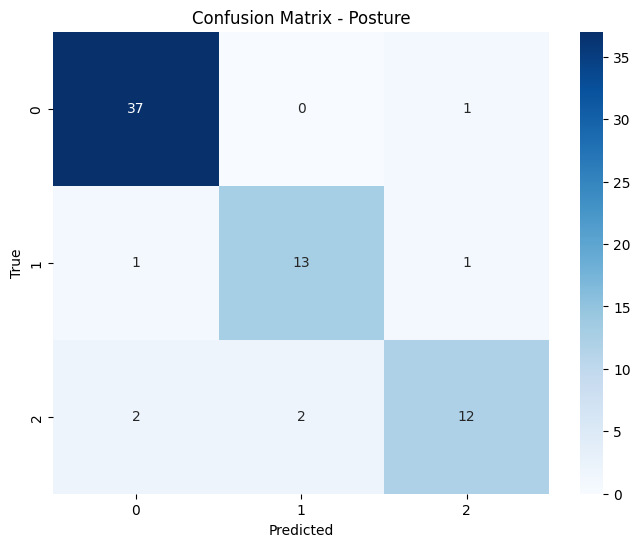

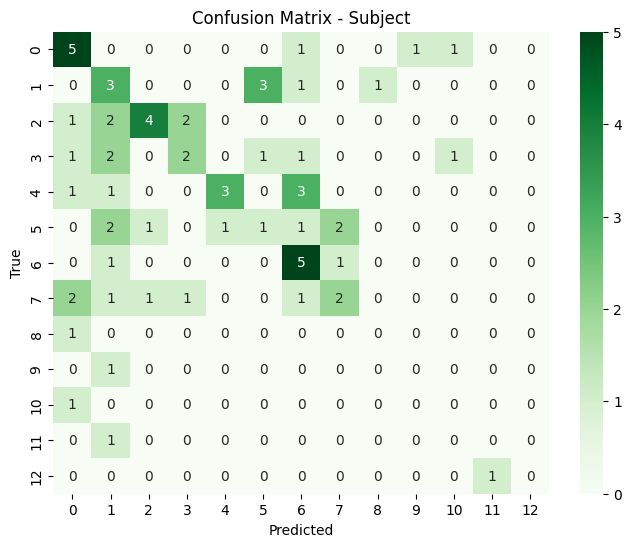

In [ ]:
conf_matrix(model_cnn2d_noaugm)
#conf_matrix(model_cnn2d_augm)
#conf_matrix(model_paper)
#conf_matrix(model_cnn2d_inception)

## DEMO

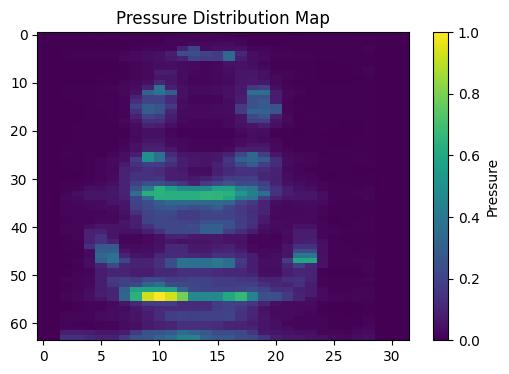

In [ ]:
ex_0_s1 = train_label_df[(train_label_df['Label'] == 0) & (train_label_df['Subject'] == 0)]

data = load_image(ex_0_s1.index[0], '../!MLHD project/Dataset')
data = remove_frames(data)
data = filtered_data(data)
data = normalize_data(data)
data = padding_2d(data)

plt.figure(figsize=(6, 4))
plt.imshow(data, cmap="viridis", aspect="auto")
plt.colorbar(label="Pressure")
plt.title('Pressure Distribution Map')
plt.show()

In [ ]:
# RIGHT CASE
data = create_dataset(ex_0_s1, batch_size=1, shuffle=False)

posture_label = ex_0_s1['Label'].values[0]
print(posture_label)
subject_label = ex_0_s1['Subject'].values[0]
posture_pred, subject_pred = model_cnn2d_noaugm.predict(data, steps=1)

posture_class = np.argmax(posture_pred, axis=1)
subject_class= np.argmax(subject_pred, axis=1)

print(f"POSTURE - Predicted: {posture_class[0]} - True: {posture_label}")
print(f"SUBJECT - Predicted: {subject_class[0]} - True: {subject_label}")

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
POSTURE - Predicted: 0 - True: 0
SUBJECT - Predicted: 0 - True: 0


Label: 0


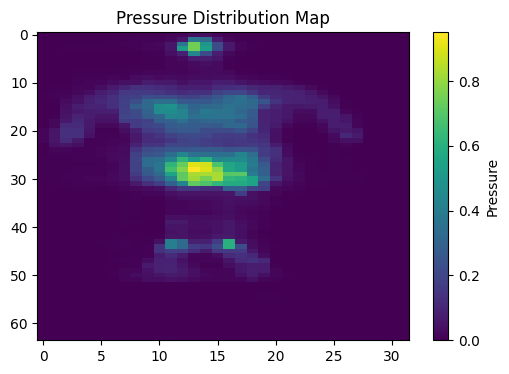

In [ ]:
# WRONG CASE FOR SUBJECT
ex_s12 = test_label_df[test_label_df['Subject'] == 12]
print('Label: ' + str(ex_s12['Label'].values[0]))


data = load_image(str(ex_s12.index[0]), '../!MLHD project/Dataset')
data = remove_frames(data)
data = filtered_data(data)
data = normalize_data(data)
data = padding_2d(data)
data = media(data)


plt.figure(figsize=(6, 4))
plt.imshow(data, cmap="viridis", aspect="auto")
plt.colorbar(label="Pressure")
plt.title('Pressure Distribution Map')
plt.show()

In [ ]:
# WRONG CASE FOR SUBJECT
data = create_dataset(ex_s12, batch_size=1, shuffle=False)

posture_label = ex_s12['Label'].values[0]
print(posture_label)
subject_label = ex_s12['Subject'].values[0]
posture_pred, subject_pred = model_cnn2d_noaugm.predict(data, steps=1)


posture_class = np.argmax(posture_pred, axis=1)
subject_class= np.argmax(subject_pred, axis=1)

print(f"POSTURE - Predicted: {posture_class[0]} - True: {posture_label}")
print(f"SUBJECT - Predicted: {subject_class[0]} - True: {subject_label}")

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
POSTURE - Predicted: 0 - True: 0
SUBJECT - Predicted: 11 - True: 12
